# <center> Depth of Customer Relationship </center>
#    <center> Using Recency, Frequency and Monetary Value (RFM) </center>

It is common for businesses to want to know the value of a customer to the business and potential income they can generate. There are many metrics to measure these interests. One technique that has gained popularity is RFM.

In this notebook, I will categorize customers using the RFM technique and create clusters using KMeans algorithm for unsupervised learning.

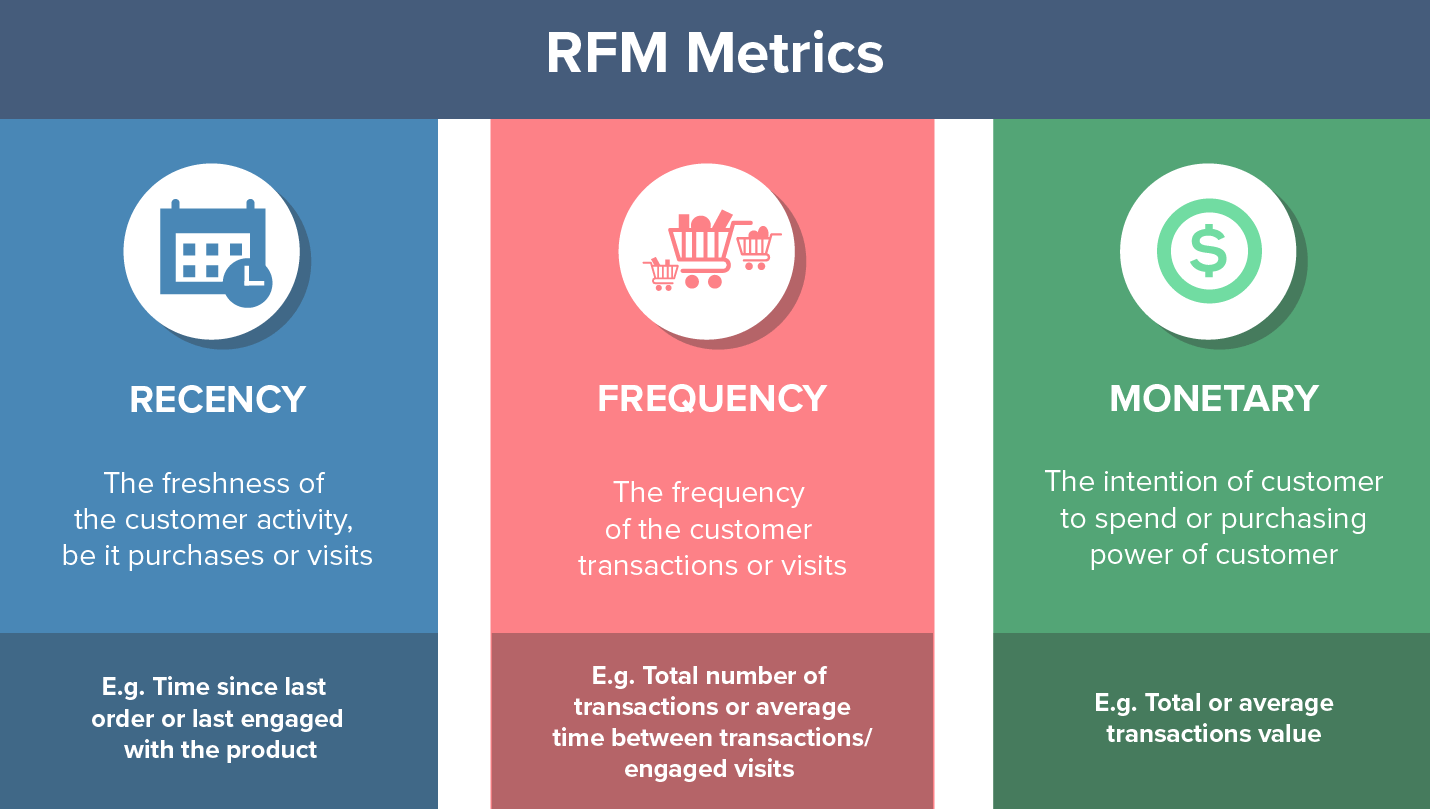

* Recency: sales people desire to always be 'in the face' of the customer. In a way, recency shows that you're at the top of your customer's mind.

* Frequency: businesses like repeat purchases. Many businesses are sustained by returning customers. Companies built around subscription models come to mind. This is why many companies reward customer loyalty.

* Monetary Value: This measures the amount of money spent by the customer. In essence, your share of the customer's wallet.

In [1]:
#import necessary libraries
import pandas as pd

#import KMeans which will be used to create clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the retail sales dataset into a dataframe
data = pd.read_csv("OnlineRetail.csv",encoding='unicode-escape')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.shape

(541909, 8)

In [6]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Assumption - Customers without a valid customer ID are those who do guest checkout when making online purchases

#drop rows without customer IDs as these would not be valid for our analysis

data = data[data.CustomerID.notna()]
data.shape

(406829, 8)

In [8]:
#Create SaleValue column by multiplying Quantity and UnitPrice columns which would be used to determine Monetary value

data['SaleValue'] = data['Quantity']* data['UnitPrice']

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [9]:
#Convert InvoiceDate to datetime type
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Change CustomerID from float to string
data['CustomerID'] = data.CustomerID.astype('Int64').astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
 8   SaleValue    406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 31.0+ MB


In [10]:
data.describe()

,Quantity,UnitPrice,SaleValue
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854
std,248.693370,69.315162,427.591718
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.200000
50%,5.000000,1.950000,11.100000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


## Calculate Recency

The recency of each customer's purchase would be calculated using the maximum date on the dataset.


In [11]:
recency = data.groupby('CustomerID').InvoiceDate.max()-data.InvoiceDate.max()
recency.head()

CustomerID
12346   -326 days +21:27:00
12347     -2 days +03:02:00
12348    -75 days +00:23:00
12349    -19 days +21:01:00
12350   -310 days +03:11:00
Name: InvoiceDate, dtype: timedelta64[ns]

In [12]:
#extract only number of days portion from recency values
#we're using these negatives so that during clustering, lower numbers will have lower scores
recency = recency.dt.days

#view top rows to see what you've done
recency.head()

CustomerID
12346   -326
12347     -2
12348    -75
12349    -19
12350   -310
Name: InvoiceDate, dtype: int64

In [13]:
#rename series to recency so that we can use that name as a column name for the RFM DataFrame we will create

recency.rename('Recency', inplace=True)

CustomerID
12346   -326
12347     -2
12348    -75
12349    -19
12350   -310
        ... 
18280   -278
18281   -181
18282     -8
18283     -4
18287    -43
Name: Recency, Length: 4372, dtype: int64

## Calculate Frequency

In [14]:
#create series with variable name 'frequency' using the aggregated counts per customer ID above

frequency = data.groupby('CustomerID').CustomerID.count()
frequency.head()

CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
Name: CustomerID, dtype: int64

In [15]:
#rename the series to 'Frequency' with a capital F. 

frequency.rename('Frequency', inplace = True)

CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
        ... 
18280     10
18281      7
18282     13
18283    756
18287     70
Name: Frequency, Length: 4372, dtype: int64

## Calculate Monetary Value

In [16]:
# create series with variable name 'monetary' using the aggregated sale value sum per customer ID 
monetary = data.groupby('CustomerID').SaleValue.sum()
monetary.head()

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
Name: SaleValue, dtype: float64

In [17]:
# Rename Series
monetary.rename('Monetary', inplace=True)

CustomerID
12346       0.00
12347    4310.00
12348    1797.24
12349    1757.55
12350     334.40
          ...   
18280     180.60
18281      80.82
18282     176.60
18283    2094.88
18287    1837.28
Name: Monetary, Length: 4372, dtype: float64

## Create DataFrame

In [18]:
RFM = pd.DataFrame(recency)

RFM.head()

,Recency
CustomerID,
12346,-326
12347,-2
12348,-75
12349,-19
12350,-310


In [19]:
RFM.reset_index(inplace=True)
RFM.head()

,CustomerID,Recency
0,12346,-326
1,12347,-2
2,12348,-75
3,12349,-19
4,12350,-310


In [20]:

RFM = RFM.merge(frequency, on='CustomerID')
RFM = RFM.merge(monetary,on='CustomerID')

#check what you've created
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,-326,2,0.00
1,12347,-2,182,4310.00
2,12348,-75,31,1797.24
3,12349,-19,73,1757.55
4,12350,-310,17,334.40


In [21]:
RFM.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,-92.043001,93.053294,1898.459701
std,100.765435,232.471608,8219.345141
min,-374.000000,1.000000,-4287.630000
25%,-143.000000,17.000000,293.362500
50%,-50.000000,42.000000,648.075000
75%,-17.000000,102.000000,1611.725000
max,0.000000,7983.000000,279489.020000


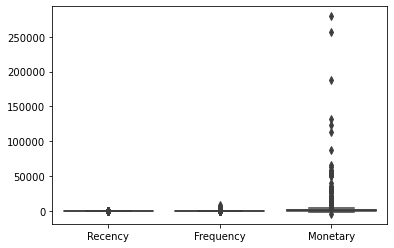

In [22]:
sns.boxplot(data=RFM)

plt.show()

## Clustering with KMeans


In [23]:
#let's set up KMeans to create 5 clusters
kmeans = KMeans(n_clusters=5,random_state=1)

In [24]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    '''
    This function is used to create a consistent order for the cluster numbers 
    that will be the output of the KMeans prediction.
    
    Parameters:
    cluster_field_name: str, name to be assigned to the cluster we are predicting for
    target_field_name: str, name of the column we're clustering 
    df: DataFrame, source of the data where prediction is to be done
    ascending: bool, order of cluster numbers
    '''
    #create column names using a prefix
    new_cluster_field_name = 'new_' + cluster_field_name
    #get mean value for the target column name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    #sort mean values in ascending order
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    #create an index
    df_new['index'] = df_new.index
    #merge the new dataframe with old dataframe
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    #remove the old column
    df_final = df_final.drop([cluster_field_name],axis=1)
    #rename the index as the metric score we want
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

### Recency Clusters

In [25]:
#fit the model
kmeans.fit(RFM[['Recency']])

#predict clusters
recency_labels = kmeans.predict(RFM[['Recency']])

#save clusters in the data frame. Replace 'pass' in the line below
RFM['Recency_Score'] = recency_labels

#order the clusters. Replace 'pass' in the line below
RFM = order_cluster('Recency_Score', 'Recency',RFM,True)

#view details of clusters
RFM.groupby('Recency_Score').Recency.describe()

,count,mean,std,min,25%,50%,75%,max
Recency_Score,,,,,,,,
0,303.0,-336.283828,26.971753,-374.0,-365.0,-331.0,-312.0,-292.0
1,442.0,-246.513575,25.619420,-291.0,-267.0,-247.0,-223.5,-202.0
2,532.0,-156.443609,25.568832,-201.0,-178.0,-156.0,-134.0,-114.0
3,1044.0,-70.369732,18.650422,-113.0,-82.0,-67.0,-54.0,-44.0
4,2051.0,-16.999025,11.969433,-43.0,-26.0,-16.0,-7.0,0.0


In [26]:
RFM.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score
0,12346,-326,2,0.00,0
1,12350,-310,17,334.40,0
2,12373,-311,14,364.60,0
3,12377,-315,77,1628.12,0
4,12386,-338,10,401.90,0


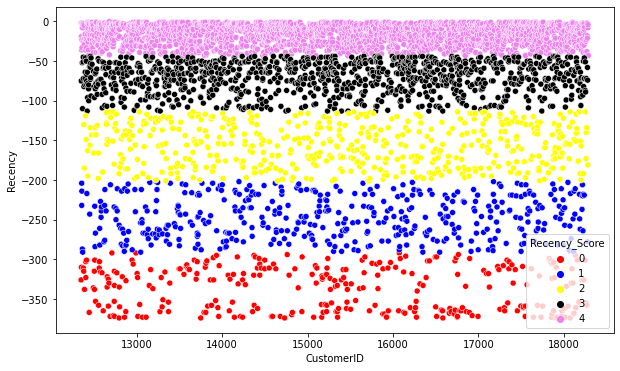

In [27]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Recency',hue='Recency_Score',data=RFM,palette=['red','blue','yellow','black','violet'])

plt.show()

### Frequency Clusters

In [28]:
#fit model
kmeans.fit(RFM[['Frequency']])

#predict clusters
frequency_labels = kmeans.predict(RFM[['Frequency']])

#save clusters in the data frame. Replace 'pass' in the line below
RFM['Frequency_Score'] = frequency_labels

#order the clusters. Replace 'pass' in the line below
RFM = order_cluster('Frequency_Score', 'Frequency',RFM,True)

#view details of clusters
RFM.groupby('Frequency_Score').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_Score,,,,,,,,
0,3277.0,34.337504,26.361525,1.0,13.00,28.0,51.0,101.0
1,866.0,170.146651,56.638151,102.0,123.00,154.0,208.0,312.0
2,203.0,456.541872,126.962074,313.0,356.50,420.0,517.5,898.0
3,22.0,1392.000000,510.778584,925.0,1064.75,1162.5,1607.0,2782.0
4,4.0,5914.000000,1473.845537,4642.0,5006.50,5515.5,6423.0,7983.0


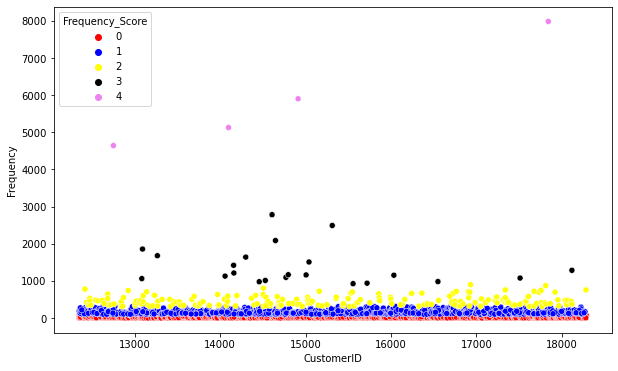

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Frequency',hue='Frequency_Score',data=RFM,palette=['red','blue','yellow','black','violet'])

plt.show()

### Monetary Value Clusters


In [30]:
#fit model
kmeans.fit(RFM[['Monetary']])
#predict clusters
monetary_labels = kmeans.predict(RFM[['Monetary']])
#save clusters in the data frame. Replace 'pass' in the line below
RFM['Monetary_Score'] = monetary_labels
#order clusters. replace 'pass' in the line below
RFM = order_cluster('Monetary_Score', 'Monetary',RFM,True)
#view details of clusters
RFM.groupby('Monetary_Score').Monetary.describe()

,count,mean,std,min,25%,50%,75%,max
Monetary_Score,,,,,,,,
0,4073.0,948.451054,968.718422,-4287.63,271.8500,594.900,1308.4800,4531.34
1,265.0,8115.962038,3762.434618,4582.64,5423.1500,6748.400,9623.3500,21535.90
2,27.0,40928.794815,13322.664031,25748.35,28865.4900,33805.690,52287.2800,65892.08
3,5.0,129057.952000,36658.292209,88125.38,113384.1400,123725.450,132572.6200,187482.17
4,2.0,267963.755000,16299.186073,256438.49,262201.1225,267963.755,273726.3875,279489.02


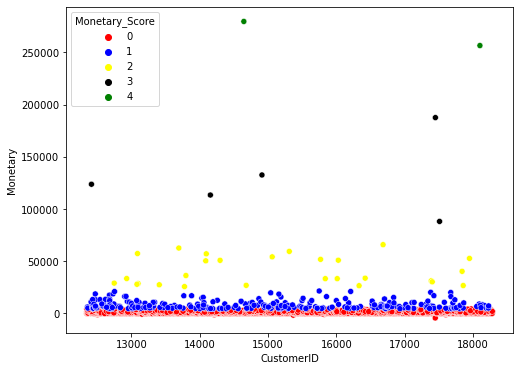

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=RFM.CustomerID.astype(int),y='Monetary',hue='Monetary_Score',data=RFM,palette=['red','blue','yellow','black','green'])

plt.show()

## Calculate Overall RFM Score

In [32]:
#create a sum of the scores 
#use sum(axis=1) to sum horizontally

RFM['Overall_Score'] = RFM[['Recency_Score','Frequency_Score','Monetary_Score']].sum(axis=1)
RFM.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score
0,12346,-326,2,0.00,0,0,0,0
1,12350,-310,17,334.40,0,0,0,0
2,12373,-311,14,364.60,0,0,0,0
3,12377,-315,77,1628.12,0,0,0,0
4,12386,-338,10,401.90,0,0,0,0


In [33]:
RFM.tail()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score
4367,14911,-1,5903,132572.62,4,4,3,11
4368,14156,-10,1420,113384.14,4,3,3,10
4369,17511,-3,1076,88125.38,4,3,3,10
4370,18102,-1,433,256438.49,4,2,4,10
4371,14646,-2,2085,279489.02,4,3,4,11


In [34]:
#check distribution of scores
RFM.Overall_Score.value_counts()

4     1318
3      916
5      567
2      495
1      438
0      295
6      205
7      103
8       21
10       6
9        6
11       2
Name: Overall_Score, dtype: int64

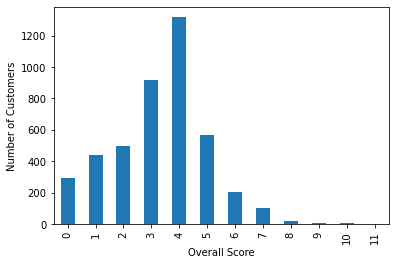

In [35]:
RFM.Overall_Score.value_counts().sort_index().plot.bar()
plt.ylabel('Number of Customers')
plt.xlabel('Overall Score')

plt.show()

In [36]:
RFM.groupby('Overall_Score').Monetary.describe()

,count,mean,std,min,25%,50%,75%,max
Overall_Score,,,,,,,,
0,295.0,283.426576,352.479252,-1192.20,120.1250,216.760,364.9350,2661.24
1,438.0,417.695685,482.419071,-141.48,162.4000,298.835,463.6575,4464.10
2,495.0,597.067699,1150.962454,-4287.63,195.3200,363.650,704.2100,21535.90
3,916.0,776.044828,853.248032,-1165.30,286.5275,535.955,1000.7450,9861.38
4,1318.0,989.362937,948.979302,-17.45,342.7000,695.230,1319.5850,11581.80
5,567.0,2409.891252,1648.306158,272.44,1322.7550,2144.530,3085.4850,12393.70
6,205.0,6004.876488,5443.288889,1052.55,3095.0400,4788.770,6336.2900,52750.84
7,103.0,11587.752136,10125.943650,3047.63,6222.7750,8234.800,12414.3700,65892.08
8,21.0,20418.507143,18054.444607,4678.30,7454.0700,10641.600,28658.8800,62653.10


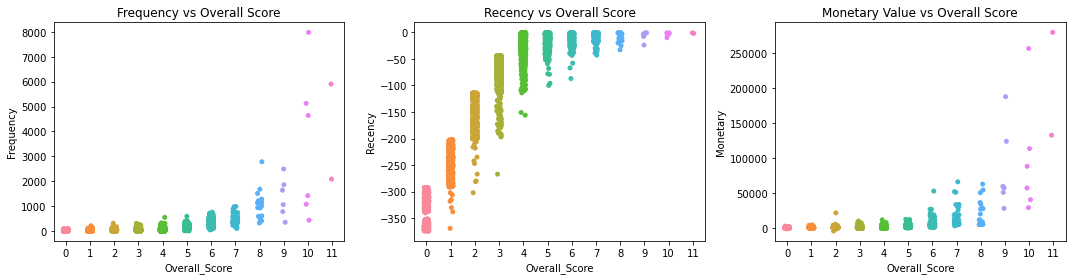

In [37]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0] = sns.stripplot(y='Frequency',x='Overall_Score',data = RFM, ax=ax[0])
ax[0].set_title('Frequency vs Overall Score')

ax[1] = sns.stripplot(y='Recency',x='Overall_Score',data = RFM, ax=ax[1])
ax[1].set_title('Recency vs Overall Score')

ax[2] = sns.stripplot(y='Monetary',x='Overall_Score',data = RFM, ax=ax[2])
ax[2].set_title('Monetary Value vs Overall Score')

plt.tight_layout()
plt.show()

### Assign Segments?

You can assign segments based on score bands. 

This will help you group customers by each of these segments so as to support business decision making.

In [38]:
#assign segments
RFM['Segment'] = 'Low Value'
RFM.loc[RFM.Overall_Score>3,'Segment'] = 'Mid Value'
RFM.loc[RFM.Overall_Score>7,'Segment'] = 'High Value'

In [39]:
RFM.head(10)

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
0,12346,-326,2,0.00,0,0,0,0,Low Value
1,12350,-310,17,334.40,0,0,0,0,Low Value
2,12373,-311,14,364.60,0,0,0,0,Low Value
3,12377,-315,77,1628.12,0,0,0,0,Low Value
4,12386,-338,10,401.90,0,0,0,0,Low Value
5,12401,-303,5,84.30,0,0,0,0,Low Value
6,12402,-323,11,225.60,0,0,0,0,Low Value
7,12410,-301,28,681.08,0,0,0,0,Low Value
8,12441,-367,11,173.55,0,0,0,0,Low Value
9,12489,-336,15,334.93,0,0,0,0,Low Value


In [40]:
RFM.tail(10)

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
4362,13089,-3,1857,57385.88,4,3,2,9,High Value
4363,14298,-3,1640,50862.44,4,3,2,9,High Value
4364,15311,-1,2491,59419.34,4,3,2,9,High Value
4365,12415,-24,778,123725.45,4,2,3,9,High Value
4366,17450,-8,351,187482.17,4,2,3,9,High Value
4367,14911,-1,5903,132572.62,4,4,3,11,High Value
4368,14156,-10,1420,113384.14,4,3,3,10,High Value
4369,17511,-3,1076,88125.38,4,3,3,10,High Value
4370,18102,-1,433,256438.49,4,2,4,10,High Value
4371,14646,-2,2085,279489.02,4,3,4,11,High Value


In [41]:
RFM.Segment.value_counts()

Mid Value     2193
Low Value     2144
High Value      35
Name: Segment, dtype: int64

In [42]:
#save to csv
RFM.to_csv('Customer_Segmentation_Analysis.csv')

In [43]:
#what are the records in one of the scores like
RFM[RFM.Overall_Score==2]


,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
2757,12383,-185,100,1839.31,2,0,0,2,Low Value
2758,12399,-119,59,1108.65,2,0,0,2,Low Value
2759,12405,-149,54,1710.39,2,0,0,2,Low Value
2760,12424,-163,30,1760.96,2,0,0,2,Low Value
2761,12426,-195,30,582.73,2,0,0,2,Low Value
...,...,...,...,...,...,...,...,...,...
3930,14670,-280,132,411.53,1,1,0,2,Low Value
3931,15235,-218,143,2247.51,1,1,0,2,Low Value
3932,17504,-206,140,2745.28,1,1,0,2,Low Value
4101,15749,-235,15,21535.90,1,0,1,2,Low Value


In [44]:
#check one person
RFM[RFM.CustomerID=='12346']

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,Overall_Score,Segment
0,12346,-326,2,0.0,0,0,0,0,Low Value


In [45]:
#why do we have records where the total monetary value is negative.
data[data.CustomerID.isin(RFM[RFM.Monetary<0].CustomerID.to_list())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleValue
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom,-41.40
...,...,...,...,...,...,...,...,...,...
411728,C572228,22113,GREY HEART HOT WATER BOTTLE,-5,2011-10-21 14:03:00,3.75,15728,United Kingdom,-18.75
411729,C572228,22112,CHOCOLATE HOT WATER BOTTLE,-17,2011-10-21 14:03:00,4.25,15728,United Kingdom,-72.25
411730,C572228,22111,SCOTTIE DOG HOT WATER BOTTLE,-10,2011-10-21 14:03:00,3.45,15728,United Kingdom,-34.50
419485,572832,M,Manual,1,2011-10-26 11:40:00,1.00,16454,United Kingdom,1.00


Campaigns can be targeted to each customer segement depending on what is determined appropriate by the business stakeholders

# Determining the Optimal Number of Clusters

## Elbow Method

In [46]:
from scipy.spatial.distance import cdist
import numpy as np

In [47]:
#to apply the elbow method to determine number of clusters
#recency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Recency']])
    clfmodel_pred = clfmodel.predict(RFM[['Recency']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Recency']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Recency']].shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Recency')

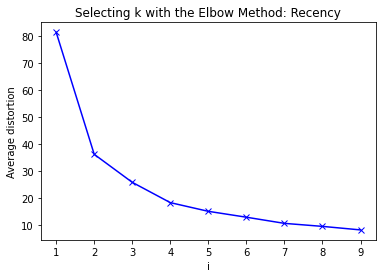

In [48]:
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Recency')

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Frequency')

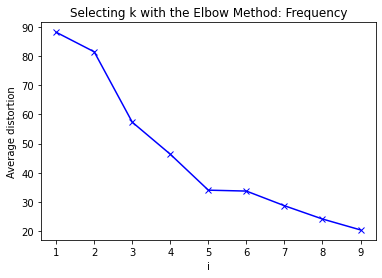

In [49]:
#to apply the elbow method to determine number of clusters
#frequency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Frequency']])
    clfmodel_pred = clfmodel.predict(RFM[['Frequency']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Frequency']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Frequency']].shape[0])
    
    
    
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Frequency')    

Text(0.5, 1.0, 'Selecting k with the Elbow Method: Monetary')

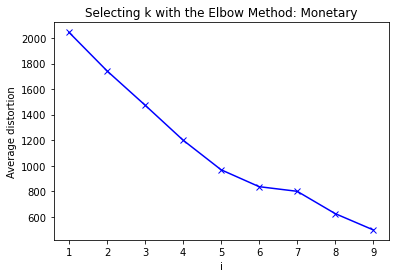

In [50]:
#to apply the elbow method to determine number of clusters
#recency
no_of_clusters = range(1,10)
meanDistortions = []

for i in no_of_clusters:
    clfmodel = KMeans(n_clusters=i)
    clfmodel.fit(RFM[['Monetary']])
    clfmodel_pred = clfmodel.predict(RFM[['Monetary']])

    meanDistortions.append(sum(np.min(cdist(RFM[['Monetary']],clfmodel.cluster_centers_,'euclidean'),axis=1)) / RFM[['Monetary']].shape[0])
    
    
#plot to find elbow    
plt.plot(no_of_clusters, meanDistortions, 'bx-')
plt.xlabel('i')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method: Monetary')    

## Silhouette Method

In [51]:
from sklearn.metrics import silhouette_score

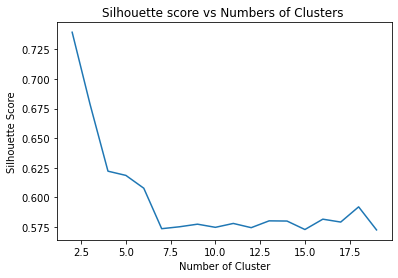

Optimal number :
2


In [52]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Recency']])
    predict = model.predict(RFM[['Recency']])
    silhouette_score(RFM[['Recency']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Recency']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)

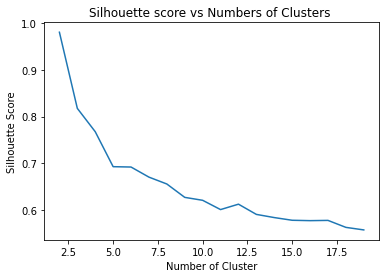

Optimal number :
2


In [53]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Frequency']])
    predict = model.predict(RFM[['Frequency']])
    silhouette_score(RFM[['Frequency']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Frequency']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)

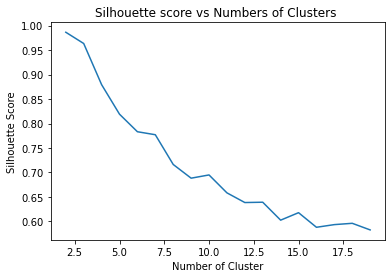

Optimal number :
2


In [54]:
silhouette  = []
no_of_cluster = range(2,20)

for i in no_of_cluster:
    model = KMeans(i,init='k-means++',n_init=10,max_iter=100,tol=0.0001, verbose=0, random_state=None, copy_x=True)
    model.fit(RFM[['Monetary']])
    predict = model.predict(RFM[['Monetary']])
    silhouette_score(RFM[['Monetary']],predict,metric='euclidean')
    silhouette.append(silhouette_score(RFM[['Monetary']],predict,metric='euclidean'))
    
plt.plot(no_of_cluster,silhouette)
plt.title("Silhouette score vs Numbers of Clusters ")
plt.xlabel('Number of Cluster')
plt.ylabel('Silhouette Score')
plt.show()

Optimal_Number=no_of_cluster[silhouette.index(max(silhouette))]
print( "Optimal number :")
print(Optimal_Number)